In [1]:
%matplotlib inline
import numpy as np
import pandas as pd     
from netCDF4 import Dataset 
import xarray as xr
#import Nio
import os

import matplotlib.pyplot as plt         # to generate plots
from mpl_toolkits.basemap import Basemap,shiftgrid,addcyclic, cm 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [12]:
# reading in the global sst data

iniyr  = 1948
endyr  = 2017
nyr    = endyr - iniyr +1

inindx = 12*(iniyr-1891)
endndx = 12*(endyr-1891+1)

ncfile1 = '/data/obs_data/COBE_SST/sst.mon.mean.nc'

fsst = xr.open_dataset(ncfile1)
fsst = fsst.assign_coords(lon=((fsst.lon + 180) % 360) - 180).sortby('lon')  # Convert lon from 0-359 to -180-179
sst =  fsst.sst[inindx:endndx,::-1,:]
lon_sst  =  fsst.lon
lat_sst   =  fsst.lat[::-1] 
time_sst = fsst.time[inindx:endndx]
sst.dims

('time', 'lat', 'lon')

In [16]:
# reading in the cpc precipitation data

inindx = 12*(iniyr-1948)
endndx = 12*(endyr-1948+1)

ncfile2 = '/data/obs_data/CPC_CONUS/monthly/precip.V1.0.mon.mean.nc'

fprc = xr.open_dataset(ncfile2)
fprc = fprc.assign_coords(lon=((fprc.lon + 180) % 360) - 180).sortby('lon')  # Convert lon from 0-359 to -180-179
prc =  fprc.precip[inindx:endndx,:,:]
lon_prc  =  fprc.lon
lat_prc  =  fprc.lat 
time_prc = fprc.time[inindx:endndx]
prc.dims

('time', 'lat', 'lon')

In [536]:
# Converting  monthly data to seasonal data 

def month_to_season(df,lst_seas):  # df should have the followng shape: [time, lat, lon]

    seasons = ['JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ','DJF']
    months  = [[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9],[8,9,10],[9,10,11],[10,11,12],[11,12,13]]

    ntime,nlat,nlon = df.shape
    nseas = len(lst_seas)
    df_seas = xr.DataArray(np.empty((nseas,int(ntime/12),nlat,nlon)),
                           [lst_seas, df['time.year'][::12], df.lat, df.lon], dims=['season', 'year', 'lat', 'lon']) 

    for seas in lst_seas:
        if seas not in seasons: raise valueError('undefinded season {}'.format(seas))
        
        mon  = list(months[y] for y in range(len(seasons)) if seas==seasons[y])
        
        if seas == 'DJF':
            df_seas.sel(season=seas)[0,:,:]=np.array((df[0,:,:].values+df[1,:,:].values)/2)
            df_seas.sel(season=seas)[1:,:,:]=np.array((df[mon[0][0]::12,:,:][:int(ntime/12)-1,:,:].values
                                                      +df[mon[0][1]::12,:,:].values
                                                      +df[mon[0][2]::12,:,:].values)/3)

        elif seas == 'NDJ':    
            df_seas.sel(season=seas)[:int(ntime/12)-1,:,:]=np.array((df[mon[0][0]::12,:,:][:int(ntime/12)-1,:,:].values
                                                                    +df[mon[0][1]::12,:,:][:int(ntime/12)-1,:,:].values
                                                                    +df[mon[0][2]::12,:,:].values)/3)
            df_seas.sel(season=seas)[-1,:,:]=np.array((df[-1,:,:].values+df[-2,:,:].values)/2)
            
        else:
            df_seas.sel(season=seas)[:]=np.array((df[mon[0][0]::12,:,:].values
                                                     +df[mon[0][1]::12,:,:].values
                                                     +df[mon[0][2]::12,:,:].values)/3)
    return df_seas                     
    
prc_seas = month_to_season(prc,['DJF','MAM','JJA','SON']) 
sst_seas = month_to_season(sst,['DJF','MAM','JJA','SON']) 
sst_seas.dims

('season', 'year', 'lat', 'lon')

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


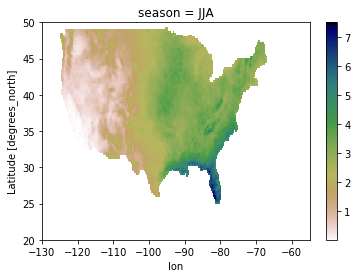

In [537]:
# plotting JJA precipiation climatology over the US and DJF SST cimatology over the globe

prc_seas.sel(season='JJA').mean(dim = 'year').plot(cmap='gist_earth_r')

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


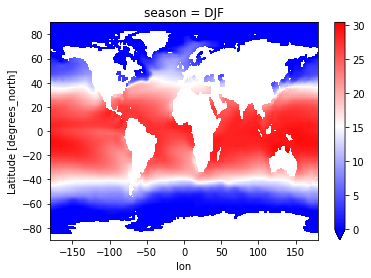

In [538]:
sst_seas.sel(season='DJF').mean(dim = 'year').plot(cmap='bwr',vmin=0)

In [539]:
# Calculating seasonal standardized anoamlies

def _standanom(var):
    return  (var - var.mean())/var.std()

def apply_standanom(da, dim):
    return xr.apply_ufunc(_standanom, da, input_core_dims=[[dim]], output_core_dims=[[dim]],
                          vectorize=True,output_dtypes=[da.dtype])

prc_seas_anom = apply_standanom(prc_seas, 'year')
sst_seas_anom = apply_standanom(sst_seas, 'year')

prc_seas_anom = prc_seas_anom.transpose(*['season','year','lat','lon'])
sst_seas_anom = sst_seas_anom.transpose(*['season','year','lat','lon'])

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [540]:
# detrending the seasonal standardized anomalies

def _detrend(var):
    import numpy.polynomial.polynomial as poly
    
    x = np.linspace(1,var.shape[0],var.shape[0])
    y = var.copy()
    b = ~np.isnan(y)
    
    if x[b].size ==0 :
        var_dtn = y
    else:
        coefs = poly.polyfit(x[b], y[b], 1)
        var_coef0 = coefs[0]
        var_coef1 = coefs[1]
        ffit = poly.polyval(x[b], coefs)
        var_dtn = y[b] - ffit + coefs[0]
    
    return var_dtn

def apply_detrend(da, dim):
    return xr.apply_ufunc(_detrend, da, input_core_dims=[[dim]], output_core_dims=[[dim]],
                          vectorize=True,output_dtypes=[da.dtype])

prc_seas_anom_dtrn = apply_detrend(prc_seas_anom, 'year')
sst_seas_anom_dtrn = apply_detrend(sst_seas_anom, 'year')

prc_seas_anom_dtrn = prc_seas_anom_dtrn.transpose(*['season','year','lat','lon'])
sst_seas_anom_dtrn = sst_seas_anom_dtrn.transpose(*['season','year','lat','lon'])

In [583]:
# broadcasting a linear regression model over lat lon dimensions

def _regcoef(x,y): 
    from  scipy import stats 
    
    b = ~np.isnan(y)
    
    if y[b].size ==0 :
        return np.nan
    else:
        return stats.linregress(x,y) #  output is a tuple of (slop, intercept, correlation, p-value, stderr )

def apply_regcoef(da,ts,dim):
    return xr.apply_ufunc(_regcoef, da, ts, input_core_dims=[[dim],[dim]], 
                          vectorize=True, output_core_dims=[[],[],[],[],[]])

# defining the US GP domain boundaries    
GP = [ 35. , 47. , -105. , -95. ] # [minlat , maxlat, minlon, maxlon] 

ts_prc_JJA_GP = prc_seas_anom_dtrn.sel(season='JJA',lat=slice(GP[0],GP[1]),lon=slice(GP[2],GP[3])).mean(dim = ['lat','lon'])

sst_DJF_prcGP_JJA_reg = apply_regcoef(sst_seas_anom_dtrn.sel(season='DJF'),ts_prc_JJA_GP,'year')
sst_MAM_prcGP_JJA_reg = apply_regcoef(sst_seas_anom_dtrn.sel(season='MAM'),ts_prc_JJA_GP,'year')
sst_JJA_prcGP_JJA_reg = apply_regcoef(sst_seas_anom_dtrn.sel(season='JJA'),ts_prc_JJA_GP,'year')

In [584]:
# writing the output to netcdf file

def tods(tp) :
    return xr.Dataset({'slope': tp[0], 'intercept': tp[1], 'correlation' : tp[2], 'p-value': tp[3], 'stderr': tp[4]})

ds_DJF = tods(sst_DJF_prcGP_JJA_reg)
ds_MAM = tods(sst_MAM_prcGP_JJA_reg)
ds_JJA = tods(sst_JJA_prcGP_JJA_reg)

ds_DJF.to_netcdf(path='./Regression_SST_DJF_with_GP_Prec_JJA_1948_2017.nc', mode='w')
ds_MAM.to_netcdf(path='./Regression_SST_MAM_with_GP_Prec_JJA_1948_2017.nc', mode='w')
ds_JJA.to_netcdf(path='./Regression_SST_JJA_with_GP_Prec_JJA_1948_2017.nc', mode='w')

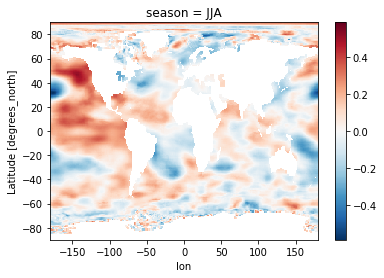

In [585]:
# plot the correlation results for JJA sst
sst_JJA_prcGP_JJA_reg[2].plot()